In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
DATA_RAW_PATH = "../data/RAW/RT-BENE.zip" 
DATA_INTER_PATH = "/opt/data/Ubuntu/projects/RT-BENE/data/intermediate"
DATA_PATH = f"{DATA_INTER_PATH}/RT-BENE"
if not os.path.exists(DATA_PATH):
    !unzip -q $DATA_RAW_PATH -d $DATA_INTER_PATH

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
data = pd.read_csv(f"{DATA_PATH}/blinks.csv")
data

,blink_id,left_eye,right_eye,video,blink
0,0,0_left_000001_rgb.png,0_right_000001_rgb.png,0,0
1,1,0_left_000002_rgb.png,0_right_000002_rgb.png,0,0
2,2,0_left_000003_rgb.png,0_right_000003_rgb.png,0,0
3,3,0_left_000004_rgb.png,0_right_000004_rgb.png,0,0
4,4,0_left_000005_rgb.png,0_right_000005_rgb.png,0,0
...,...,...,...,...,...
107345,107345,16_left_009059_rgb.png,16_right_009059_rgb.png,16,0
107346,107346,16_left_009060_rgb.png,16_right_009060_rgb.png,16,0
107347,107347,16_left_009061_rgb.png,16_right_009061_rgb.png,16,0
107348,107348,16_left_009062_rgb.png,16_right_009062_rgb.png,16,0


### How many videos do we have?

In [5]:
video_ids = np.unique(data["video"])
video_ids

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Total images

In [6]:
data["blink_id"].count()

107350

### How many images per video?

In [7]:
data_per_video = data.groupby(by=["video"]).count()
blinks_per_video = data.loc[data["blink"] == 1].groupby(by="video").count()
blinks_per_video = blinks_per_video.div(data_per_video, level="video") * 100
data_per_video = pd.concat([data_per_video["blink_id"], blinks_per_video["blink"]], axis=1, keys=["Images in video","% blink frames"])
data_per_video

,Images in video,% blink frames
video,,
0,12865,7.236689
1,8671,1.476185
2,8702,9.066881
3,3205,5.210608
4,4750,2.736842
5,5355,2.054155
7,1857,8.023694
8,6108,7.514735
9,4210,1.068884


Previous data shows that a rebalancing method will have to be used

### Create Dataset
To have a proper test partition we are going to separate the dataset in two sets of videos. One will be used for training and the other one for testing.
We will select the videos ids 13, 14, 16 as the testing videos because it's images represent around 20% of the total dataset and the percentage of blinks is similar to the rest of the dataset

#### Split train and test sets

In [8]:
testing_ids = [13,14,16]
validation_ids = [8]
training_ids = np.delete(video_ids, np.array(testing_ids)-1)
training_ids = np.delete(training_ids, np.array(validation_ids)-1)
training_ids = training_ids.tolist()
print(f"train: {training_ids}\nvalidation: {validation_ids}\ntesting: {testing_ids}")

train: [0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 15]
validation: [8]
testing: [13, 14, 16]


In [9]:
train_data = data.loc[data["video"].isin(training_ids)]
print(f"train_data: {train_data.shape[0]}")
val_data = data.loc[data["video"].isin(validation_ids)]
print(f"val_data: {val_data.shape[0]}")
test_data = data.loc[data["video"].isin(testing_ids)]
print(f"test_data: {test_data.shape[0]}")

train_data: 81736
val_data: 6108
test_data: 19506


#### Generic generator class

In [18]:
import cv2
class RTBeneDataset:
    def __init__(self, phase: str, data: pd.DataFrame, mean: float, std: float, transforms = None):
        self.phase = phase
        self.data = data
        self.mean = mean
        self.std = std
        self.transforms = transforms
        self.counter = 0
        
        if self.phase == "train":
            #Shuffle the data
            self.data = self.data.sample(frac=1).reset_index(drop=True)
        else:
            self.data = self.data.reset_index(drop=True)
            
            
    def __getitem(self, idx):
        row = self.data.loc[idx,["left_eye", "right_eye"]].to_list(), self.data.loc[idx,["blink"]].to_list()[0]
        return row
    
    def __call__(self):
        for i in range(self.data.shape[0]):
            yield self.__getitem(i)
            self.counter +=1
            
            if self.counter == (self.data.shape[0] -1):
                # When all the dataset is readed, reshuffle again
                self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    @staticmethod
    @tf.function
    def tf_load_row(x, y):
        image_l = tf.io.read_file(tf.strings.join([f"{DATA_PATH}/images/", x[0]]))
        image_r = tf.io.read_file(tf.strings.join([f"{DATA_PATH}/images/", x[1]]))
        image_l = tf.image.decode_png(image_l, channels=3)
        image_r = tf.image.decode_png(image_r, channels=3)
        return (image_l, image_r), y
    
def set_shapes(imgs, label, img_shape=(36,60,3)):
        imgs[0].set_shape(img_shape)
        imgs[1].set_shape(img_shape)
        label.set_shape([])
        return imgs, label

## Resampling to get better distribution of the data

In [19]:
train_blink_RTB = RTBeneDataset("train", train_data.loc[train_data["blink"] == 1], 127.5, 1)
train_no_blink_RTB = RTBeneDataset("train", train_data.loc[train_data["blink"] == 0], 127.5, 1)
val_RTB = RTBeneDataset("val", val_data, 127.5, 1)
test_RTB = RTBeneDataset("val", test_data, 127.5, 1)

### Data augmentation

In [20]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

In [41]:
transforms = Compose([
            Rotate(limit=20),
            RandomBrightness(limit=0.2),
            JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

def scale(image, label):
    return (tf.cast(image[0], tf.float32)/255.0, tf.cast(image[1], tf.float32)/255.0), label

def process_data(image, label):
    aug_img_l = tf.numpy_function(func=aug_fn, inp=[image[0]], Tout=tf.uint8)
    aug_img_r = tf.numpy_function(func=aug_fn, inp=[image[1]], Tout=tf.uint8)
    return (aug_img_l, aug_img_r), label

/home/esteve/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/esteve/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
/home/esteve/.local/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [49]:
batch_size = 256

blink_dataset = tf.data.Dataset.from_generator(train_blink_RTB, 
                                               output_types=(tf.string, tf.uint8), 
                                               output_shapes=((2),()))

no_blink_dataset = tf.data.Dataset.from_generator(train_no_blink_RTB, 
                                                  output_types=(tf.string, tf.uint8), 
                                                  output_shapes=((2),()))

train_dataset  = tf.data.Dataset.sample_from_datasets([blink_dataset, no_blink_dataset], [0.4, 0.6], stop_on_empty_dataset=True)\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(process_data, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size)\
    .repeat()


val_dataset = tf.data.Dataset.from_generator(val_RTB, 
                                               output_types=(tf.string, tf.uint8), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)\
    .batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(test_RTB, 
                                               output_types=(tf.string, tf.uint8), 
                                               output_shapes=((2),()))\
    .map(RTBeneDataset.tf_load_row, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(scale, num_parallel_calls=tf.data.AUTOTUNE)\
    .prefetch(tf.data.AUTOTUNE)\
    .batch(batch_size)

### Test image augmentations

In [50]:
it = train_dataset.as_numpy_iterator()

[1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1
 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0]


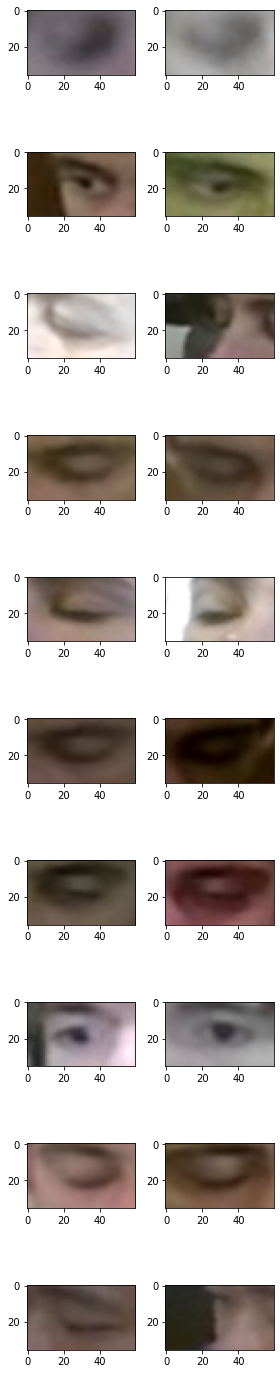

In [51]:
for data in it:
    print(data[1])
    fig,axs = plt.subplots(10,2, figsize=(4,20))
    for i in range(10):
        axs[i,0].imshow(data[0][0][i])
        axs[i,1].imshow(data[0][1][i])
    fig.tight_layout()
    break

### Create model

In [52]:
from tensorflow import keras
from tensorflow.keras import regularizers, initializers, layers
from tensorflow.keras.applications import DenseNet121

In [68]:
left_eye = keras.Input(shape=(36, 60, 3))
right_eye = keras.Input(shape=(36, 60, 3))
vgg_left = DenseNet121(weights="imagenet", include_top=False, input_shape=(36, 60, 3))
vgg_left._name = "vgg_left"
for layer in vgg_left.layers:
    layerkernel_regularizer=regularizers.l1(1e-3),
vgg_right = DenseNet121(weights="imagenet", include_top=False, input_shape=(36, 60, 3))
vgg_right._name = "vgg_right"
for layer in vgg_right.layers:
    layerkernel_regularizer=regularizers.l1(1e-3),
left_feat_extractor = vgg_left(left_eye)
right_feat_extractor = vgg_right(right_eye)
concat = layers.Concatenate()([left_feat_extractor, right_feat_extractor])
flat = layers.Flatten()(concat)
dense_1 = layers.Dense(256, activation="relu",
                      kernel_regularizer=regularizers.l2(1e-5),
                       kernel_initializer=initializers.GlorotNormal)(flat)
do_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(128, activation="relu",
                      kernel_regularizer=regularizers.l2(1e-5),
                       kernel_initializer=initializers.GlorotNormal)(do_1)
do_2 = layers.Dropout(0.2)(dense_2)
out = layers.Dense(1, activation="sigmoid")(do_2)

model = keras.Model(inputs=([left_eye, right_eye]), outputs=out, name="vgg_fetext_data_rebalanced_aug_dropout")
model.summary()

Model: "vgg_fetext_data_rebalanced_aug_dropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 36, 60, 3)]  0           []                               
                                                                                                  
 vgg_left (Functional)          (None, 1, 1, 1024)   7037504     ['input_33[0][0]']               
                                                                                                  
 vgg_right (Functional)         (None, 1, 1, 1024)   7037504     ['input_34[0][0]']               
                                                             

In [69]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), F1_score])

In [70]:
from datetime import datetime

run_id = f'{model.name}-{datetime.now().strftime("%m-%H%M%S")}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"models/{run_id}/" + "{epoch:02d}-{val_F1_score:.2f}",
    save_weights_only=True,
    monitor='val_F1_score',
    mode='max',
    save_best_only=False)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{run_id}", update_freq=100,)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)

history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=40, 
          steps_per_epoch=int(train_data.shape[0]/(2*batch_size)), 
          validation_steps=int(val_data.shape[0]/batch_size),
          callbacks=[model_checkpoint_callback, tensorboard_callback, reduce_lr_callback])

Epoch 1/40
159/159 [==============================] - 85s 454ms/step - loss: 0.1206 - binary_accuracy: 0.9538 - precision_9: 0.9412 - recall_9: 0.9426 - F1_score: 0.9391 - val_loss: 0.4015 - val_binary_accuracy: 0.8524 - val_precision_9: 0.3354 - val_recall_9: 0.9977 - val_F1_score: 0.5000 - lr: 0.0010
Epoch 2/40
159/159 [==============================] - 71s 445ms/step - loss: 0.0433 - binary_accuracy: 0.9865 - precision_9: 0.9831 - recall_9: 0.9831 - F1_score: 0.9831 - val_loss: 0.1424 - val_binary_accuracy: 0.9594 - val_precision_9: 0.6613 - val_recall_9: 0.9339 - val_F1_score: 0.7761 - lr: 0.0010
Epoch 3/40
159/159 [==============================] - 67s 421ms/step - loss: 0.0351 - binary_accuracy: 0.9893 - precision_9: 0.9869 - recall_9: 0.9860 - F1_score: 0.9864 - val_loss: 0.0648 - val_binary_accuracy: 0.9757 - val_precision_9: 1.0000 - val_recall_9: 0.6743 - val_F1_score: 0.8003 - lr: 0.0010
Epoch 4/40
159/159 [==============================] - 69s 436ms/step - loss: 0.0298 - bi

InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/esteve/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/esteve/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_485125/2721295122.py", line 16, in <module>
      history = model.fit(train_dataset,
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1420, in fit
      val_logs = self.evaluate(
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1474, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/esteve/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/esteve/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/esteve/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/esteve/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_485125/2721295122.py", line 16, in <module>
      history = model.fit(train_dataset,
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1420, in fit
      val_logs = self.evaluate(
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1474, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/esteve/.local/lib/python3.9/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (vgg_fetext_data_rebalanced_aug_dropout/dense_26/Sigmoid:0) = ] [[nan][nan][nan]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_41]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (vgg_fetext_data_rebalanced_aug_dropout/dense_26/Sigmoid:0) = ] [[nan][nan][nan]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_626690]

In [75]:
model.load_weights("models/vgg_fetext_data_rebalanced_aug_dropout-02-180821/08-0.84")

In [76]:
results = model.evaluate(test_dataset)

77/77 [==============================] - 15s 195ms/step - loss: 0.3227 - binary_accuracy: 0.9144 - precision_9: 0.2453 - recall_9: 0.9746 - F1_score: 0.3797
